In [45]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre
from scipy.integrate import quad

NOTE : For detailed derivations of expressions, refer the analytical script of Stark Effect

In [46]:
def hydrogen_radial(n, l, r):
    """Standard Hydrogen Radial Wavefunction R_nl(r)"""
    n, l = int(n), int(l)
    
    prefactor = np.sqrt((2.0 / n)**3 * math.factorial(n - l - 1) / (2.0 * n * math.factorial(n + l)))
    laguerre_poly = genlaguerre(n - l - 1, 2 * l + 1)
    
    rho = 2.0 * r / n
    return prefactor * np.exp(-r / n) * (rho ** l) * laguerre_poly(rho)

$$
R_{nl}(r) = \sqrt{\frac{(2/n)^3\, (n-l-1)!}{2n\, (n+l)!}}\, e^{-r/n}\, \left(\frac{2r}{n}\right)^l\, L_{n-l-1}^{2l+1}\left(\frac{2r}{n}\right)
$$

In [47]:
def compute_matrix_element(state_i, state_j):
    n_i, l_i, m_i = state_i
    n_j, l_j, m_j = state_j
    
# By conservation of angular momentum z operator cannot change m
    if m_i != m_j:
        return 0.0
# If the integral in total is odd, the integral is zero
    if abs(l_i - l_j) != 1:
        return 0.0
    
    angular_factor = 1.0 / np.sqrt(3.0)
    # the function below is taken from quadratic stark effect code
    def integrand(r):
        return hydrogen_radial(n_i, l_i, r) * r * hydrogen_radial(n_j, l_j, r) * (r**2)
    radial_val, error = quad(integrand, 0, np.inf)
    
    return radial_val * angular_factor

In [48]:
basis_set = [
    (2, 0, 0),  # 2s,0
    (2, 1, 0),  # 2p,0
    (2, 1, 1),  # 2p,1
    (2, 1, -1)  # 2p,-1
]

W = np.zeros((4, 4))

In [49]:
# the rules for the matrix elements are already defined above
for i in range(4):
    for j in range(4):
        W[i, j] = compute_matrix_element(basis_set[i], basis_set[j])
        

        
print("\n 4x4 Perturbation Matrix W:")
print(np.round(W, 2))


 4x4 Perturbation Matrix W:
[[ 0. -3.  0.  0.]
 [-3.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]


In [ ]:
W_reduced = W[0:2, 0:2]
eigenvalues, eigenvectors = np.linalg.eigh(W_reduced)
vec_1 = eigenvectors[0]
vec_2 = eigenvectors[1]

print("\nReduced 2x2 Matrix (m=0 subspace):")
print(np.round(W_reduced, 2))
print("\nEigenvalues (Energy Shifts):")
print(eigenvalues)

#The calculation yields eigenvalues of -2.9 and +2.9. 
# This confirms the energy shift is Linear: Delta_E = +/- 3 * e * E_field * a_0


Reduced 2x2 Matrix (m=0 subspace):
[[ 0. -3.]
 [-3.  0.]]

Eigenvalues (Energy Shifts):
[-3.  3.]


In [52]:
print(f"State 1 (Shift {eigenvalues[0]:.1f}): {vec_1[0]:.3f}|200> + {vec_1[1]:.3f}|210>")
print(f"State 2 (Shift {eigenvalues[1]:.1f}): {vec_2[0]:.3f}|200> + {vec_2[1]:.3f}|210>")
# The new wavefunctions are SP-hybrids (polarized orbitals).

State 1 (Shift -3.0): -0.707|200> + -0.707|210>
State 2 (Shift 3.0): -0.707|200> + 0.707|210>


$$
\psi_{2s} = \frac{1}{4\sqrt{2\pi}} (2 - R) e^{-R/2}
$$

$$
\psi_{2p} = \frac{1}{4\sqrt{2\pi}} R \cos\theta\, e^{-R/2}
$$

Lower Energy State (Electron shifts against field)


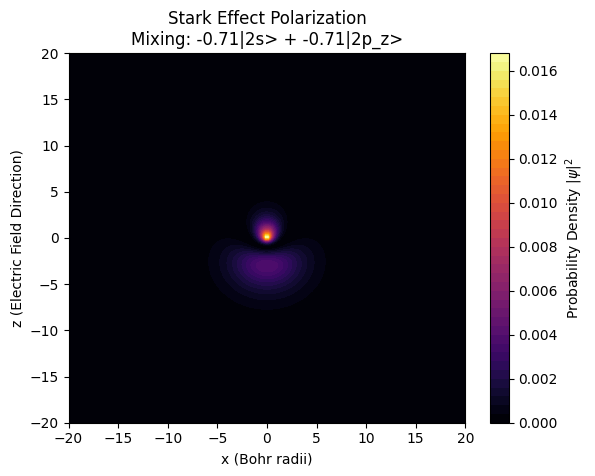

Higher Energy State (Electron shifts wiyh field)


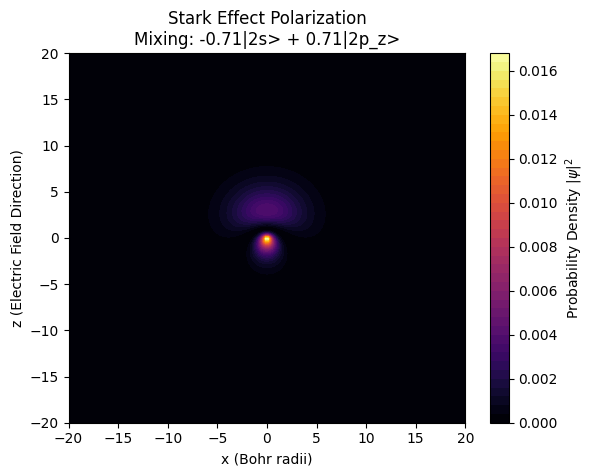

In [54]:
def plot_stark_density(coeffs):
    
    c_s, c_p = coeffs[0], coeffs[1]
    
    limit = 20  # Plot up to 20 Bohr radii
    points = 200
    x = np.linspace(-limit, limit, points)
    z = np.linspace(-limit, limit, points)
    X, Z = np.meshgrid(x, z)
    
    R = np.sqrt(X**2 + Z**2)
    Theta = np.arctan2(X, Z)
    
    psi_2s = (1.0 / (4 * np.sqrt(2 * np.pi))) * (2 - R) * np.exp(-R/2)#n,l,m=2,0,0
    psi_2p = (1.0 / (4 * np.sqrt(2 * np.pi))) * R * np.cos(Theta) * np.exp(-R/2)#n,l,m=2,1,0
    
    psi_total = (c_s * psi_2s) + (c_p * psi_2p)
    density = psi_total**2
    
    plt.contourf(X, Z, density, levels=50, cmap='inferno')
    plt.colorbar(label='Probability Density $|\psi|^2$')
    
    plt.title(f"Stark Effect Polarization\nMixing: {c_s:.2f}|2s> + {c_p:.2f}|2p_z>")
    plt.xlabel("x (Bohr radii)")
    plt.ylabel("z (Electric Field Direction)")
    
    plt.show()
    
print("Lower Energy State (Electron shifts against field)")
plot_stark_density(eigenvectors[0])

print("Higher Energy State (Electron shifts wiyh field)")
plot_stark_density(eigenvectors[1])

In [56]:
help(np.zeros_like)

Help on _ArrayFunctionDispatcher in module numpy:

zeros_like(a, dtype=None, order='K', subok=True, shape=None, *, device=None)
    Return an array of zeros with the same shape and type as a given array.
    
    Parameters
    ----------
    a : array_like
        The shape and data-type of `a` define these same attributes of
        the returned array.
    dtype : data-type, optional
        Overrides the data type of the result.
    order : {'C', 'F', 'A', or 'K'}, optional
        Overrides the memory layout of the result. 'C' means C-order,
        'F' means F-order, 'A' means 'F' if `a` is Fortran contiguous,
        'C' otherwise. 'K' means match the layout of `a` as closely
        as possible.
    subok : bool, optional.
        If True, then the newly created array will use the sub-class
        type of `a`, otherwise it will be a base-class array. Defaults
        to True.
    shape : int or sequence of ints, optional.
        Overrides the shape of the result. If order='K' 

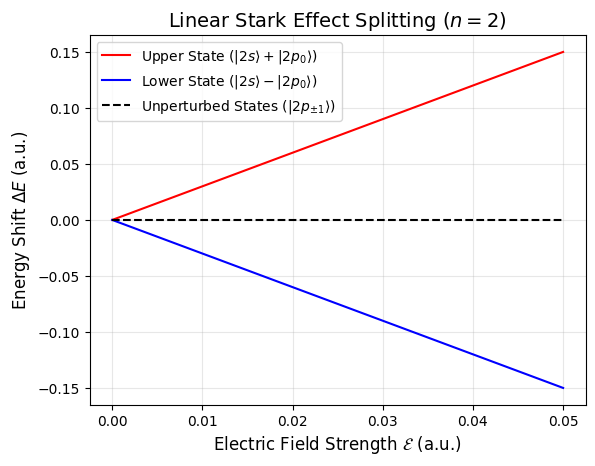

In [60]:
E_field = np.linspace(0, 0.05, 100)  # 0 to 0.05 a.u.

delta_E_plus = eigenvalues[1] * E_field
delta_E_minus = eigenvalues[0] * E_field
delta_E_zero = np.zeros_like(E_field)

plt.plot(E_field, delta_E_plus, 'r-', label=r'Upper State ($|2s\rangle + |2p_0\rangle$)')
plt.plot(E_field, delta_E_minus, 'b-', label=r'Lower State ($|2s\rangle - |2p_0\rangle$)')
plt.plot(E_field, delta_E_zero, 'k--', label=r'Unperturbed States ($|2p_{\pm 1}\rangle$)')

plt.title(r'Linear Stark Effect Splitting ($n=2$)', fontsize=14)
plt.xlabel(r'Electric Field Strength $\mathcal{E}$ (a.u.)', fontsize=12)
plt.ylabel(r'Energy Shift $\Delta E$ (a.u.)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()